# Training Set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from scipy.stats import zscore
from sklearn.feature_extraction.text import TfidfTransformer
%matplotlib inline

### Read raw training data that was created in Stage 0

In [2]:
amazon = pd.read_csv('../amazon_data/raw_data_train.csv')
print(amazon.shape)

(364000, 14)


### Restructure helpful score
After the first submission, I changed the helpful score to be more lenient and slightly higher (more strict) when considering the helful denominator.  

In [3]:
amazon['helpful'] = (amazon['helpScore']>=.67) & (amazon['HelpfulnessDenominator']>4)
# print(amazon['helpful'])




### Remove NaN
I also removed helpScores that were NaN

In [4]:
amazon = amazon[np.isfinite(amazon['helpScore'])]
print(amazon.shape)

(190908, 14)


In [5]:
# V = set(amazon['Text'])
# amazon[long_words] = [w for w in set(amazon['Text']) if len(w) > 13]
# sorted(set(amazon['Text']))
# amazon['v'] = amazon[word_count]
# print(amazon['v'])

### This view provides the first five lines of the data

In [6]:
print(amazon.head())
print(amazon['helpful'].mean())


   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      233579        314180  314181  B002EDIJX6  A29J8R14DE7J5D   
1      328779        277777  277778  B002OMV09W   A20FWCIY7HIAQ   
2       42396        161359  161360  B008O3G2K2  A1QBOC76MIOJYP   
4      378479        287581  287582  B000IEHR6S  A2G31BUNV2GD70   
5      218113         87153   87154  B000FGCA16  A169QQNCP4W4P2   

         ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  Score  \
0  R. Hill "msrhook"                     2                       2      5   
1  Ryan L. Wilkinson                     1                       1      5   
2          MyPenName                     1                       2      2   
4            oldsoup                     4                       4      2   
5       Douglas Hoag                     2                       2      5   

         Time                                 Summary  \
0  1320105600                         cookie memories   
1  1312329600      3

### Feature extraction on natural language data - this step creates a large matrix.  It was the code that was used for a previous in-class assignment.
Using NLTK and k-means clustering, I tried to see if there was a way to cluster the two groups and distinguish the differences in common words between helpful and not helpful scores.  It was not very useful, and the process of tokenizing and clustering took a long time.  I can see why hashing is so useful.

In [7]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())

### A hashing method is used to create matrix that is smaller in size and easier to work with.

In [8]:
# vectorize Bag of Words from review text; as sparse matrix
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(n_features=2 ** 17, non_negative=True, ngram_range=(1,3))
X_hv = hv.fit_transform(amazon.Text)
print(X_hv.shape)

/Users/hubideal/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/Users/hubideal/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


(190908, 131072)


### This code creates a pickle file so we can treat the training and test set the same way.  

In [9]:
# We want to be able to use this model fit on other data (the test set)
# So let's save a copy of this instance of HashingVectorizer to be able to transform other data with this fit
# http://scikit-learn.org/stable/modules/model_persistence.html
joblib.dump(hv, 'hv.pkl') # pickle

['hv.pkl']

### This step is optional:  Transformation on the word counts can sometimes improves performance.  
##### notes:  Should I keep or not.  Term frequency.  IDF Inverse document frequency.  is the total number of documents divided by the number of documents that contain the term (log of this). idf is weighting.  reduces the weight of less influential words.  Like "and"  

In [10]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
transformer = TfidfTransformer()
X_tfidf = transformer.fit_transform(X_hv)

joblib.dump(transformer, 'transformer.pkl') # pickle

['transformer.pkl']

In [11]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

#####  Note:  This is where I can add and remove features.  

In [12]:
# amazon['reviewLen'] = zscore(amazon['Text'].str.len())
# amazon['summaryLen'] = amazon['Summary'].str.len()
# amazon['userIdLen'] = zscore(amazon['UserId'].str.len())
# amazon['idLen'] = zscore(amazon['Id'])
# amazon['profileLen'] = amazon['ProfileName'].str.len()
# amazon['zScore'] = zscore(amazon['Score'])

amazon['reviewLen'] = amazon['Text'].str.len()
amazon['summaryLen'] = amazon['Summary'].str.len()
amazon['wordCount'] = amazon['Text'].str.split().apply(len)

amazon['wordArray'] = amazon['Text'].str.split()
amazon['wordArrayLen'] = amazon['wordArray'].str.len()
amazon['userIdLen'] = amazon['UserId'].str.len()
amazon['idLen'] = amazon['Id']
amazon['profileLen'] = amazon['ProfileName'].str.len()
amazon['zScore'] = amazon['Score']
amazon['avgWord'] = amazon['reviewLen']/amazon['wordCount']

In [13]:
amazon['summaryLen'].fillna(0, inplace=True)
print(np.any(np.isnan(amazon['summaryLen'])))

False


In [14]:
amazon['profileLen'].fillna(0, inplace=True)
print(np.any(np.isnan(amazon['profileLen'])))

False


In [15]:
# from nltk.tokenize import word_tokenize as WordTokenizer

# def custom_tokenize(text):
#     if not text:
#         print('The text to be tokenized is a None type. Defaulting to blank string.')
#         text = ''
#     return WordTokenizer(text)
# amazon['tokenize'] = amazon['Text'].apply(custom_tokenize)

#amazon['cols'] = df.blocks['object'].amazon['wordArray']
# def word_tokenizer(amazon, wordArray):
#     token=[]
#     for item in amazon['wordArray']:
#          token.append(WordTokenizer(item))

#     return token

# token = word_tokenizer(amazon, 'wordArray')
# df. insert(index, 'token_column', token)

# print(nltk.FreqDist(amazon["tokens"]))

In [16]:
# amazon['summaryLen'] = zscore(amazon['summaryLen'])
# amazon['profileLen'] = zscore(amazon['profileLen'])



def word_counter(text):
    counter=0
    for word in text:
        if word == "is" or word == 'are' or word == "was" or word == "were" or word == "can" or word == "could" or word == "will" or word == "would" or word == "become" or word == "have" or word == "has" or word == "had":
            counter=counter+1
    return counter

amazon['wordCount'] = amazon['wordArray'].apply(word_counter)
amazon['passivePer'] = amazon['wordCount'] / amazon['wordArrayLen']



In [17]:
# def word_counter(text):
#     counter=0
#     for word in text:
#         if word == "excellent" or word == 'yum' or word == "good" or word == "dog" or word == "dogs" or word == "!" or word == "fantastic" or word == "helpful" or word == "product" or word == "bought" or word == "recommend":
#             counter=counter+1
#     return counter

# amazon['wordCount2'] = amazon['wordArray'].apply(word_counter)
# amazon['goodWords'] = amazon['wordCount2'] / amazon['wordArrayLen']


In [18]:
def word_capitalize(text):
    counter=0
    for word in text:
        #if word == 'tea' or word == 'get' or word == 'years' or word == 'oil' or word == 'cat' or word == 'quality' or word == 'milk' or word == 'less' or word == 'brand' or word == 'give' or word == 'lot' or word == 'stuff' or word == 'ingredients' or word == 'back':
        if  word == 'love' or word == 'taste' or word =='liked' or word =="n't" or word =='great' or word =='good' or word =='flavors' or word =='product' or word =='very' or word =='using' or word =='just' or word =='trying' or word =='buy' or word =='food' or word =='make' or word =='order' or word =='price' or word =='eating' or word =='time' or word =='best' or word =='really' or word =='only' or word =='amazon' or word =='little' or word =='stores' or word =="'ve" or word =='better' or word =='because' or word =='did' or word =='does' or word =="'m" or word =='any' or word =='br' or word =='br' or word =='verified' or word =='purchased': 
        #word == 'I' or word == 'you' or word == 'my' or word == 'like' or word == 'good' or word == 'one' or word == 'food' or word == 'all' or word == 'more' or word == 'very' or word == 'product' or word == 'taste' or word == 'out' or word == 'me' or word == 'flavor' or word == 'tea' or word == 'great' or word == 'coffee' or word == 'get' or word == 'up' or word == 'use' or word == 'only' or word == 'no' or word == 'much' or word == 'we' or word == 'little' or word == 'time' or word == 'love' or word == 'My' or word == 'too' or word == 'make' or word == 'tried' or word == 'Amazon' or word == 'find' or word == 'best' or word == 'better' or word == 'water' or word == 'price' or word == 'eat' or word == 'used' or word == 'dog' or word == 'buy' or word == 'now' or word == 'first' or word == 'try' or word == 'found' or word == 'We' or word == 'sugar' or word == 'cup' or word == 'then' or word == 'made' or word == 'over' or word == '2' or word == 'our' or word == 'day' or word == 'years' or word == 'oil' or word == 'chocolate' or word == 'cat' or word == 'know' or word == 'box' or word == 'bought' or word == 'think' or word == 'store' or word == 'go' or word == 'quality' or word == 'want' or word == 'recommend' or word == 'milk' or word == 'less' or word == 'mix' or word == 'never' or word == 'brand' or word == 'without' or word == 'every' or word == 'You' or word == 'sweet' or word == 'give' or word == 'lot' or word == 'again' or word == 'drink' or word == 'stuff' or word == 'order' or word == 'ingredients' or word == 'back' or word == 'got' or word == 'tastes' or word == '1' or word == 'makes' or word == 'say':
            counter=counter+1
                
    return counter

amazon['wordCapitalize'] = amazon['wordArray'].apply(word_capitalize)
amazon['capitalism'] = amazon['wordCapitalize'] / amazon['wordArrayLen']


In [19]:
# amazon['avgWord'] = zscore(amazon['avgWord'])
# amazon["Score"] = zscore(amazon["Score"])
# amazon["passivePer"] = zscore(amazon["passivePer"])
# amazon['capitalism'] = zscore(amazon['capitalism'])
# amazon["mystery"] = zscore(amazon['Unnamed: 0'])
# amazon["Time"] = zscore(amazon['Time'])

In [20]:
# features from Amazon.csv to add to feature set
# amazon['reviewLen'] = amazon['Text'].str.len()
# amazon['profileLen'] = (amazon['ProfileName'].str.len())/1

#"zScore", 'avgWord', 'userIdLen', 'wordCount', "Score", 'Unnamed: 0' , 'wordCount','goodWords', 'capitalism', 'passivePer'
X_quant_features = amazon[[ 'Score', 'avgWord', 'passivePer', 'capitalism']]
print(X_quant_features.head(10))
print(type(X_quant_features))

    Score   avgWord  passivePer  capitalism
0       5  4.906250    0.046875    0.062500
1       5  5.130000    0.040000    0.010000
2       2  5.142450    0.045584    0.048433
4       2  5.622951    0.114754    0.000000
5       5  5.547368    0.084211    0.021053
10      5  5.238095    0.047619    0.023810
12      4  4.666667    0.117647    0.058824
16      5  5.409091    0.075758    0.045455
17      5  5.178571    0.053571    0.053571
18      1  4.765957    0.063830    0.085106
<class 'pandas.core.frame.DataFrame'>


### Combine all quantitative features into a single sparse matrix

##### Note:  This creates a CSR Matrix.  Horizontal stack so we can concatenate horizontally.  spare matrix.  and combine them hstack from the bag of words and horizontally conatenate that.  Add to two columns.  using the sparse data structure.  Single sparse matrix.   

In [21]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(190908, 131076)


### Create `X`, scaled matrix of features

##### Note:  Nomralize everything on the same scale.  Use the standard scaler which takes an input matrix.  the two new columns that are added are the same as the count of the words.  

In [22]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X = sc.fit_transform(X_matrix)
print(X.shape)

joblib.dump(sc, 'sc.pkl') # pickle

(190908, 131076)


['sc.pkl']

### create `y`, vector of Labels

In [23]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


### fit models - I will focus on the Linear model for the first assignment.  

In [24]:
from my_measures import BinaryClassificationPerformance

##### Note;  In my original iteration, I just focused on using the defaults.  fit the support vector machine with the x and y variables.  Take a snap shot of that fit for the test v.  92% accuracy.  Lots of false positive and false negatives.  SVM - look at graph.  We are really only fitting on proximity.  closest points to the point of delineation (line).  

In [25]:
# MODEL: SVM, linear
from sklearn import linear_model
svm = linear_model.SGDClassifier(alpha= .0001)
svm.fit(X, y)
joblib.dump(svm, 'svm.pkl') # pickle

svm_performance = BinaryClassificationPerformance(svm.predict(X), y, 'svm')
svm_performance.compute_measures()
print(svm_performance.performance_measures)

/Users/hubideal/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


{'Pos': 30030, 'Neg': 160878, 'TP': 28692, 'TN': 158555, 'FP': 2323, 'FN': 1338, 'Accuracy': 0.98082322375175479, 'Precision': 0.92510075769788813, 'Recall': 0.95544455544455542, 'desc': 'svm'}


In [26]:
# # MODEL: SVM, linear
# from sklearn import linear_model
# svm = linear_model.SGDClassifier(alpha=.000001)
# svm.fit(X, y)
# joblib.dump(svm, 'svm.pkl') # pickle

# svm_performance = BinaryClassificationPerformance(svm.predict(X), y, 'svm')
# svm_performance.compute_measures()
# print(svm_performance.performance_measures)

##### Notes on log regression:  Introduce new models.  this one is logistic regression.  The other are Naive Bayes and ridge regression.  These are all variatons of the linear model.  Linear regression is difficult to fit sometimes - crude.  How can we get better results from it.  Outcome the logistic regression is bianary.  Assumed to be bianary.  Log of the outcome.  Actually its the log of the probability of the outcome.  We think of it as what is the probility of one given everything else.  the likihood of the outcome being one or true and transform it into a distribution.  All of these transfomrations happen on the x side.  We can play around with the defaults.  alpha scores.  

In [27]:
# MODEL: logistic regression
from sklearn import linear_model

lgs = linear_model.SGDClassifier(loss='log', max_iter=10, alpha=.01)
lgs.fit(X, y)
joblib.dump(lgs, 'lgs.pkl') # pickle
    
lgs_performance = BinaryClassificationPerformance(lgs.predict(X), y, 'lgs')
lgs_performance.compute_measures()

print(lgs_performance.performance_measures)

{'Pos': 30030, 'Neg': 160878, 'TP': 29784, 'TN': 160675, 'FP': 203, 'FN': 246, 'Accuracy': 0.99764808179856268, 'Precision': 0.99323039983993067, 'Recall': 0.9918081918081918, 'desc': 'lgs'}


In [28]:
# # MODEL: logistic regression
# from sklearn import linear_model
# lgs = linear_model.SGDClassifier(loss='log', alpha=.000001)
# lgs.fit(X, y)
# joblib.dump(lgs, 'lgs.pkl') # pickle

# lgs_performance = BinaryClassificationPerformance(lgs.predict(X), y, 'lgs')
# lgs_performance.compute_measures()
# print(lgs_performance.performance_measures)

##### Notes on Naive Bayes.  P(Y|X) = P(X|Y)P(Y)/P(x)  Y is informed by taking a look at x.  We start witht he probability of x given the probility of y.  multiplyed the probility of y divided by the probility x.   adding naive becasue its impossible to assume all of are xs are independent of each other.  We aregoing to pretend that the xs are independent.  Breaking assumptions. 

##### Notes on Ridge Regression:  Since we are trying to find things that are good.  FP is high for the ridge regression - which is good.  it is the closest to the linear model.  The only difference is that you are using a regulaization for the coefficients.  This is a term down weights every coefficient.  Therefore, it makes it harder for any individual to be really strong predictor of the outcome.  As alpha become smaller the weight can become bigger.  Ridge is weighting down the weights.  Beyond ridge there are implementions of ridge that allow you specific different alphas, etc.  There is a implementation of Naive Bayes that is a ridge naive bayes.  

In [29]:
# MODEL: Naive Bayes
from sklearn.naive_bayes import MultinomialNB

nbs = MultinomialNB(alpha=.1)
nbs.fit(X, y)
joblib.dump(nbs, 'nbs.pkl') # pickle
    
nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'nbs')
nbs_performance.compute_measures()

print(nbs_performance.performance_measures)

{'Pos': 30030, 'Neg': 160878, 'TP': 23334, 'TN': 142448, 'FP': 18430, 'FN': 6696, 'Accuracy': 0.86838686697257317, 'Precision': 0.5587108514510104, 'Recall': 0.77702297702297707, 'desc': 'nbs'}


In [30]:
# MODEL: Ridge Regression Classifier
from sklearn import linear_model


#alphaTerm=[.000001, .00001, .0001, .0001, .001, .01, .1, 1, 2, 3, 5, 9, 10, 50, 100, 200, 300, 1000, 10000]
#for i in range(len(alphaTerm)):
rdg = linear_model.RidgeClassifier(alpha=9050, normalize=True, fit_intercept=True, max_iter=100)
rdg.fit(X, y)
joblib.dump(rdg, 'rdg.pkl') # pickle
    
rdg_performance = BinaryClassificationPerformance(rdg.predict(X), y, 'rdg')
rdg_performance.compute_measures()
print(rdg_performance.performance_measures)

{'Pos': 30030, 'Neg': 160878, 'TP': 13529, 'TN': 141656, 'FP': 19222, 'FN': 16501, 'Accuracy': 0.81287845454354979, 'Precision': 0.41308662330921192, 'Recall': 0.45051615051615052, 'desc': 'rdg'}


We'll talk about this one next week.  

In [31]:
# # MODEL: Perceptron
# from sklearn import linear_model
# prc = linear_model.SGDClassifier(loss='perceptron', eta0=6, max_iter=20, alpha=.1)
# prc.fit(X, y)
# joblib.dump(prc, 'prc.pkl') # pickle

# prc_performance = BinaryClassificationPerformance(prc.predict(X), y, 'prc')
# prc_performance.compute_measures()
# print(prc_performance.performance_measures)

In [32]:
# # MODEL: Perceptron
# from sklearn import linear_model
# alphaTerm=[.00001, .0001, .001, .01, .1, 1, 2, 10, 20, 40, 50, 60, 70]
# for i in range(len(alphaTerm)):
#     prc = linear_model.SGDClassifier(loss='perceptron', eta0=12, max_iter=20, alpha = alphaTerm[i]) #, alpha=2
#     prc.fit(X, y)
#     joblib.dump(prc, 'prc.pkl') # pickle
#     prc_performance = BinaryClassificationPerformance(prc.predict(X), y, 'prc')
#     prc_performance.compute_measures()
#     print(alphaTerm[i])
#     print(prc_performance.performance_measures)

In [33]:
# MODEL: Perceptron
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron', eta0=4, max_iter=42, alpha=10)
prc.fit(X, y)
joblib.dump(prc, 'prc.pkl') # pickle

prc_performance = BinaryClassificationPerformance(prc.predict(X), y, 'prc')
prc_performance.compute_measures()
print(prc_performance.performance_measures)

{'Pos': 30030, 'Neg': 160878, 'TP': 29729, 'TN': 160634, 'FP': 244, 'FN': 301, 'Accuracy': 0.99714522178221976, 'Precision': 0.99185934007273213, 'Recall': 0.98997668997668997, 'desc': 'prc'}


In [34]:
# # MODEL: Perceptron
# from sklearn import linear_model
# prc = linear_model.SGDClassifier(loss='perceptron', eta0=6, max_iter=20, alpha=.1)
# prc.fit(X, y)
# joblib.dump(prc, 'prc.pkl') # pickle

# prc_performance = BinaryClassificationPerformance(prc.predict(X), y, 'prc')
# prc_performance.compute_measures()
# print(prc_performance.performance_measures)

### ROC plot to compare performance of various models and fits

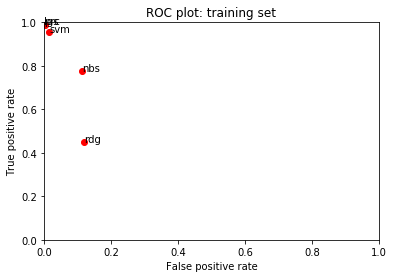

In [35]:
#fits = [svm_performance, lgs_performance, nbs_performance, rdg_performance, prc_performance]
fits = [svm_performance, lgs_performance, nbs_performance, rdg_performance, prc_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'ro')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()